In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [16]:
x1, xi, cm, cM = sp.symbols('x_1 x_i c_m c_M')
a, n           = sp.symbols('a n')

x1 = cm**(-a) / (cm**(-a) + (n-1)*cM**(-a))
xi = cM**(-a) / (cm**(-a) + (n-1)*cM**(-a))

C = x1 * cm + xi * (n-1) * cM
C

c_M*(n - 1)/(c_M**a*(c_m**(-a) + (n - 1)/c_M**a)) + c_m/(c_m**a*(c_m**(-a) + (n - 1)/c_M**a))

In [20]:
x1 * cm

c_m/(c_m**a*(c_m**(-a) + (n - 1)/c_M**a))

In [19]:
sp.simplify(x1 * cm)

c_M**a*c_m/(c_M**a + c_m**a*(n - 1))

In [21]:
xi * cM

c_M/(c_M**a*(c_m**(-a) + (n - 1)/c_M**a))

In [26]:
sp.simplify(xi * cM * (n-1))

c_M*c_m**a*(n - 1)/(c_M**a + c_m**a*(n - 1))

In [28]:
sp.simplify(sp.simplify(x1 * cm)+ sp.simplify((n-1)*xi * cM))

(c_M*c_m**a*(n - 1) + c_M**a*c_m)/(c_M**a + c_m**a*(n - 1))

In [29]:
sp.simplify(C)

(c_M*c_m**a*(n - 1) + c_M**a*c_m)/(c_M**a + c_m**a*(n - 1))

In [35]:
num, den = sp.fraction(sp.simplify(C))
num

c_M*c_m**a*(n - 1) + c_M**a*c_m

In [37]:
sp.simplify(num / (cm**a))

c_M*n - c_M + c_M**a*c_m/c_m**a

In [39]:
sp.simplify(den / (cm**a))

c_M**a/c_m**a + n - 1

# total cost

In [64]:
R, n, a = sp.symbols('R n a')

C = R * (R**(a-1) + n - 1) / (R**a + n - 1)

C

R*(R**(a - 1) + n - 1)/(R**a + n - 1)

In [65]:
sp.limit(C, n, sp.oo)

R

# sanity check

In [42]:
x1, xi, cm, cM = sp.symbols('x_1 x_i c_m c_M')
a, n           = sp.symbols('a n')

x1 = cm**(-a) / (cm**(-a) + (n-1)*cM**(-a))
xi = cM**(-a) / (cm**(-a) + (n-1)*cM**(-a))

C = x1 * cm + xi * (n-1) * cM
C

c_M*(n - 1)/(c_M**a*(c_m**(-a) + (n - 1)/c_M**a)) + c_m/(c_m**a*(c_m**(-a) + (n - 1)/c_M**a))

In [44]:
cFast = sp.lambdify((cm, cM, a, n), C)
cFast

<function _lambdifygenerated(c_m, c_M, a, n)>

In [86]:
cFast(1, 10, 10, 10)

1.0000000081

# all bid max

In [88]:
xi, cM = sp.symbols('x_i c_M')
a, n   = sp.symbols('a n')

xi = cM**(-a) / (n*cM**(-a))

C = n* xi * cM
C

c_M

# system solver for multiple players

In [514]:
# two player
c1, c2, v1, v2 = sp.symbols('c_1 c_2 v_1 v_2')
a = 3

u1 = (c1-v1) * (1/c1)**a / ((1/c1)**a + (1/c2)**a)
u2 = (c2-v2) * (1/c2)**a / ((1/c1)**a + (1/c2)**a)
u1

(c_1 - v_1)/(c_1**3*(c_2**(-3) + c_1**(-3)))

In [515]:
part1 = sp.diff(u1, c1)
part2 = sp.diff(u2, c2)
foc1 = sp.Eq(part1, 0)
foc2 = sp.Eq(part2, 0)
foc2

Eq(1/(c_2**3*(c_2**(-3) + c_1**(-3))) - 3*(c_2 - v_2)/(c_2**4*(c_2**(-3) + c_1**(-3))) + 3*(c_2 - v_2)/(c_2**7*(c_2**(-3) + c_1**(-3))**2), 0)

In [517]:
foc1sc = sp.lambdify((c1, c2), part1.evalf(subs={v1:1}))
foc2sc = sp.lambdify((c1, c2), part2.evalf(subs={v2:1}))

def eqs(cs):
    c1, c2 = cs
    return [foc1sc(c1,c2), foc2sc(c1,c2)]

initial_guess = [0.4, 0.2]
solution = fsolve(eqs, initial_guess)
solution

array([3., 3.])

In [98]:
x1 = (1/solution[0])**(3) / ((1/solution[0])**(3) + (1/solution[1])**(3))
x2 = (1/solution[1])**(3) / ((1/solution[0])**(3) + (1/solution[1])**(3))
x1, x2

(0.4312151766251178, 0.5687848233748822)

In [159]:
# three player
c1, c2, c3, v1, v2, v3 = sp.symbols('c_1 c_2 c_3 v_1 v_2 v_3')
a = 9

u1 = (c1-v1) * (1/c1)**a / ((1/c1)**a + (1/c2)**a + (1/c3)**a)
u2 = (c2-v2) * (1/c2)**a / ((1/c1)**a + (1/c2)**a + (1/c3)**a)
u3 = (c3-v3) * (1/c3)**a / ((1/c1)**a + (1/c2)**a + (1/c3)**a)
u1

(c_1 - v_1)/(c_1**9*(c_3**(-9) + c_2**(-9) + c_1**(-9)))

In [160]:
part1 = sp.diff(u1, c1)
part2 = sp.diff(u2, c2)
part3 = sp.diff(u3, c3)
foc1 = sp.Eq(part1, 0)
foc2 = sp.Eq(part2, 0)
foc3 = sp.Eq(part3, 0)
foc2

Eq(1/(c_2**9*(c_3**(-9) + c_2**(-9) + c_1**(-9))) - 9*(c_2 - v_2)/(c_2**10*(c_3**(-9) + c_2**(-9) + c_1**(-9))) + 9*(c_2 - v_2)/(c_2**19*(c_3**(-9) + c_2**(-9) + c_1**(-9))**2), 0)

In [161]:
foc1sc = sp.lambdify((c1, c2, c3), part1.evalf(subs={v1:1}))
foc2sc = sp.lambdify((c1, c2, c3), part2.evalf(subs={v2:2}))
foc3sc = sp.lambdify((c1, c2, c3), part3.evalf(subs={v3:4}))

def eqs(cs):
    c1, c2, c3 = cs
    return [foc1sc(c1,c2,c3), foc2sc(c1,c2,c3), foc3sc(c1,c2,c3)]

initial_guess = [1, 1, 1]
solution = fsolve(eqs, initial_guess)
solution

array([2.02462415, 2.33171154, 4.50033163])

In [162]:
x1 = (1/solution[0])**(a) / ((1/solution[0])**(a) + (1/solution[1])**(a) + (1/solution[2])**(a))
x2 = (1/solution[1])**(a) / ((1/solution[0])**(a) + (1/solution[1])**(a) + (1/solution[2])**(a))
x3 = (1/solution[2])**(a) / ((1/solution[0])**(a) + (1/solution[1])**(a) + (1/solution[2])**(a))
x1, x2, x3, x1+x2+x3

(0.7804480416310342, 0.2189627850780753, 0.0005891732908904957, 1.0)

In [335]:
# n-player
n = 5
a = 3
cs, vs, us = [], [], []
for i in range(1,n+1):
    c_i = sp.symbols('c_{}'.format(i))
    v_i = sp.symbols('v_{}'.format(i))
    cs.append(c_i)
    vs.append(v_i)
denom = sum([(1/c)**a for c in cs])
for i in range(1,n+1):
    u_i = (cs[i-1] - vs[i-1]) * (1/cs[i-1])**a / denom
    us.append(u_i)
us[0]

(c_1 - v_1)/(c_1**3*(c_5**(-3) + c_4**(-3) + c_3**(-3) + c_2**(-3) + c_1**(-3)))

In [339]:
focs = []
vals = np.arange(1.,n+1)**2
for i in range(n):
    parti = sp.diff(us[i], cs[i])
    vi = vs[i]
    focs.append(sp.lambdify(cs, parti.evalf(subs={vi: vals[i]})))
focs[-1]

<function _lambdifygenerated(c_1, c_2, c_3, c_4, c_5)>

In [342]:
vals

array([ 1.,  4.,  9., 16., 25.])

In [343]:
def eqs(cs):
    return [f(*cs) for f in focs]

initial_guess = vals
solution = fsolve(eqs, initial_guess)
solution

array([ 7.46801654e+00,  8.73152668e+00,  2.08400439e+06,  1.52874658e+06,
       -1.46985588e+07])

In [344]:
allodenom = sum([1/(s**a) for s in solution])
allocs = [1/(s**a) / allodenom for s in solution]
allocs

[0.6151310326499437,
 0.38486896735005616,
 2.83065905033675e-17,
 7.17095428995606e-17,
 -8.06787557215077e-20]

In [345]:
np.dot(allocs, solution)

7.954302385239493

In [494]:
# verify this one with empirics

In [576]:
init = vals
a    = 3
n    = 5
vals = [1.,4.,9.,16.,25.]

cs = [sp.Symbol('c_{}'.format(i), positive=True) for i in range(1, n+1)]
bids = [[init[i]] for i in range(n)]
for turn in range(int(1000)):
    i = turn % n
    den = sum([1/(ci**a) for ci in cs])
    xi = 1/(cs[i]**a) / den
    ui = (cs[i]-vals[i])*xi
    subs = {}
    for j in range(n):
        if j != i:
            subs[cs[j]] = bids[j][-1]
    funci = sp.lambdify([cs[i]], -ui.evalf(subs=subs))
    bounds = ((0, 1000),)
    sol = minimize(funci, (1.1), method='SLSQP', bounds=bounds).x[0]
    curri = sol
    bids[i].append(curri)

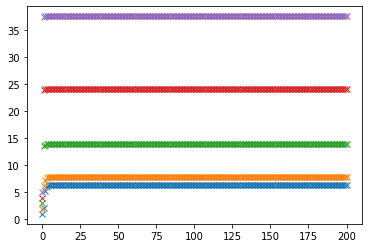

In [577]:
plt.plot(bids[0], marker='x', linestyle='none')
plt.plot(bids[1], marker='x', linestyle='none')
plt.plot(bids[2], marker='x', linestyle='none')
plt.plot(bids[3], marker='x', linestyle='none')
plt.plot(bids[4], marker='x', linestyle='none')

In [578]:
bids[0][-1],bids[1][-1],bids[2][-1],bids[3][-1],bids[4][-1]

(6.386416442200648,
 7.873363006311625,
 13.930090079545378,
 24.1296761037661,
 37.50600098985183)

In [579]:
vals

[1.0, 4.0, 9.0, 16.0, 25.0]

In [580]:
cs, vs, us = [], [], []
for i in range(1,n+1):
    c_i = sp.symbols('c_{}'.format(i))
    v_i = sp.symbols('v_{}'.format(i))
    cs.append(c_i)
    vs.append(v_i)
denom = sum([(1/c)**a for c in cs])
for i in range(1,n+1):
    u_i = (cs[i-1] - vs[i-1]) * (1/cs[i-1])**a / denom
    us.append(u_i)
us[-1]

(c_5 - v_5)/(c_5**3*(c_5**(-3) + c_4**(-3) + c_3**(-3) + c_2**(-3) + c_1**(-3)))

In [581]:
focs = []
for i in range(n):
    parti = sp.diff(us[i], cs[i])
    vi = vs[i]
    focs.append(sp.lambdify(cs, parti.evalf(subs={vi: vals[i]})))
focs[-1]

<function _lambdifygenerated(c_1, c_2, c_3, c_4, c_5)>

In [582]:
parti.evalf(subs={vi: vals[i]})

1/(c_5**3*(c_5**(-3) + c_4**(-3) + c_3**(-3) + c_2**(-3) + c_1**(-3))) - 3.0*(c_5 - 25.0)/(c_5**4*(c_5**(-3) + c_4**(-3) + c_3**(-3) + c_2**(-3) + c_1**(-3))) + 3.0*(c_5 - 25.0)/(c_5**7*(c_5**(-3) + c_4**(-3) + c_3**(-3) + c_2**(-3) + c_1**(-3))**2)

In [605]:
def eqs(cs):
    return [f(*cs) for f in focs]
fsolve(eqs, [6., 7., 13., 24., 27.]), fsolve(eqs, vals)

(array([ 6.38821323,  7.87627169, 13.93135   , 24.13685419, 37.5560592 ]),
 array([ 7.46801654e+00,  8.73152668e+00,  2.08400439e+06,  1.52874658e+06,
        -1.46985588e+07]))

In [608]:
focs[0](
    6.38641653292105,
    7.873363006311625,
    13.93008972601651,
    24.12967651253459,
    37.50600131187707
)

-2.566491214928135e-05

# WELFARE

In [242]:
# two player
a  = sp.symbols('a')
vs = []
n  = 5
for i in range(1,n+1):
    v_i = sp.symbols('v_{}'.format(i), positive=True)
    vs.append(v_i)
vs

[v_1, v_2, v_3, v_4, v_5]

In [247]:
W = - sum([(v)**(1-a) for v in vs]) / sum([(v)**(-a) for v in vs])
W = sp.simplify(W)
W

-(v_1**(1 - a) + v_2**(1 - a) + v_3**(1 - a) + v_4**(1 - a) + v_5**(1 - a))/(v_5**(-a) + v_4**(-a) + v_3**(-a) + v_2**(-a) + v_1**(-a))

In [351]:
n = 5
a = 3
cand1 = np.ones(n)
cand2 = np.arange(1,n+1, dtype=np.float)
cand3 = np.arange(1,n+1, dtype=np.float)**(1/2)
cand4 = np.ones(n)
cand4[-1] = n
cand5 = np.ones(n) * n
cand5[0] = 1
cand6 = np.power(np.arange(1.,n+1), 2)
cands = [cand1, cand2, cand3, cand4, cand5, cand6]
cands

[array([1., 1., 1., 1., 1.]),
 array([1., 2., 3., 4., 5.]),
 array([1.        , 1.41421356, 1.73205081, 2.        , 2.23606798]),
 array([1., 1., 1., 1., 5.]),
 array([1., 5., 5., 5., 5.]),
 array([ 1.,  4.,  9., 16., 25.])]

In [352]:
def calcTruthfulCost(cand, a):
    v1 = np.min(cand)
    num = sum([np.power(vi,1-a)/v1 for vi in cand])
    den = sum([np.power(vi,-a) for vi in cand])
    return num/den

In [613]:
def calcEquilBids(cand, n, a, guess=None):
    cs, vs, us = [], [], []
    for i in range(1,n+1):
        c_i = sp.symbols('c_{}'.format(i))
        v_i = sp.symbols('v_{}'.format(i))
        cs.append(c_i)
        vs.append(v_i)
    denom = sum([(1/c)**a for c in cs])
    for i in range(1,n+1):
        u_i = (cs[i-1] - vs[i-1]) * (1/cs[i-1])**a / denom
        us.append(u_i)

    focs = []
    for i in range(n):
        parti = sp.diff(us[i], cs[i])
        vi = vs[i]
        focs.append(sp.lambdify(cs, parti.evalf(subs={vi: cand[i]})))

    def eqs(cs):
        return [f(*cs) for f in focs]

    initial_guess = cand
    if guess:
        initial_guess = guess
    return fsolve(eqs, initial_guess)

def calcEquilCost(cand, bids, a):
    v1 = np.min(cand)
    num = 0
    den = 0
    for i in range(len(cand)):
        ci, vi = bids[i], cand[i]
        num += (vi*np.power(ci,-a)/v1)
        den += (np.power(ci,-a))
    return num / den

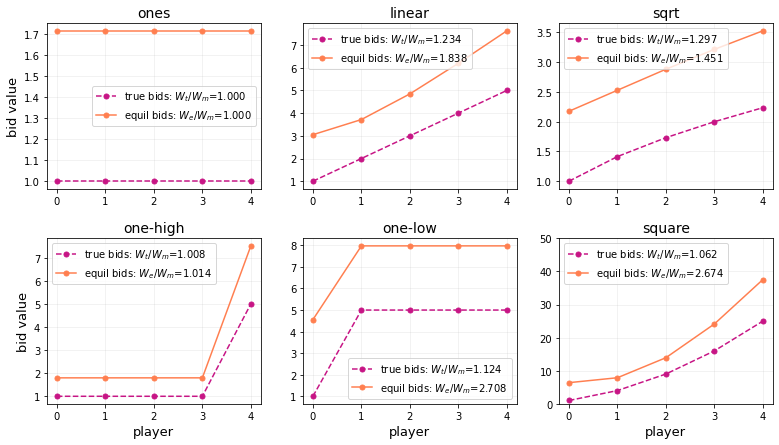

In [615]:
f, axarr = plt.subplots(nrows=2, ncols=3, figsize=(13,7))

candNames = ['ones', 'linear', 'sqrt', 'one-high', 'one-low', 'square']
for i, c in enumerate(cands):
    row, col = i // 3, i % 3
    
    truthCost = calcTruthfulCost(c, a=3)
    if i == 5: # requires hand crafted init guess
        bids = calcEquilBids(c, n=5, a=3, guess=[6., 7., 13., 24., 27.])
    else:
        bids = calcEquilBids(c, n=5, a=3)
    for j in range(len(bids)):
        if np.abs(bids[j]) > float(1e5):
            bids[j] = 0
    equilCost = calcEquilCost(c, bids, a=3)
    
    axarr[row,col].plot(np.arange(n), c, color='mediumvioletred', alpha=1, 
                        label=r'true bids: $W_t/W_m$={:0.3f}'.format(truthCost), marker='o', fillstyle='full', 
                        linestyle='--', markersize=5)
    axarr[row,col].plot(np.arange(n), bids, color='coral', alpha=1, 
                        label='equil bids: $W_e/W_m$={:0.3f}'.format(equilCost), marker='o', fillstyle='full', 
                        linestyle='-', markersize=5)

    axarr[row,col].set_title(candNames[i], size=14)
    axarr[row,col].legend()
    axarr[row,col].grid(alpha=0.2)


    
axarr[0,0].set_ylabel('bid value', size=13)
axarr[1,0].set_ylabel('bid value', size=13)
axarr[1,0].set_xlabel('player', size=13)
axarr[1,1].set_xlabel('player', size=13)
axarr[1,2].set_xlabel('player', size=13)

axarr[1,2].set_ylim(0, 50)


plt.subplots_adjust(hspace=0.3)
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# payments

In [616]:
n = 5
a = 3
cand1 = np.ones(n)
cand2 = np.arange(1,n+1, dtype=np.float)
cand3 = np.arange(1,n+1, dtype=np.float)**(1/2)
cand4 = np.ones(n)
cand4[-1] = n
cand5 = np.ones(n) * n
cand5[0] = 1
cand6 = np.power(np.arange(1.,n+1), 2)
cands = [cand1, cand2, cand3, cand4, cand5, cand6]
cands

[array([1., 1., 1., 1., 1.]),
 array([1., 2., 3., 4., 5.]),
 array([1.        , 1.41421356, 1.73205081, 2.        , 2.23606798]),
 array([1., 1., 1., 1., 5.]),
 array([1., 5., 5., 5., 5.]),
 array([ 1.,  4.,  9., 16., 25.])]

In [623]:
def calcTruthfulPayment(cand, a): # SAME AS TRUTHFUL WELFARE
    v1 = np.min(cand)
    num = sum([np.power(vi,1-a)/v1 for vi in cand])
    den = sum([np.power(vi,-a) for vi in cand])
    return num/den

In [629]:
def calcEquilPayment(cand, bids, a):
    v1 = np.min(cand)
    num = 0
    den = 0
    for i in range(len(cand)):
        ci, vi = bids[i], cand[i]
        num += (np.power(ci,1-a)/v1) # MAYBE V2 instead of V1?!
        den += (np.power(ci,-a))
    return num / den

In [630]:
bids = calcEquilBids(cands[-1], n=5, a=3, guess=[6., 7., 13., 24., 27.])
cands[-1], bids

(array([ 1.,  4.,  9., 16., 25.]),
 array([ 6.38821323,  7.87627169, 13.93135   , 24.13685419, 37.5560592 ]))

In [631]:
calcEquilPayment(cands[-1], bids, a)

7.600053122618369

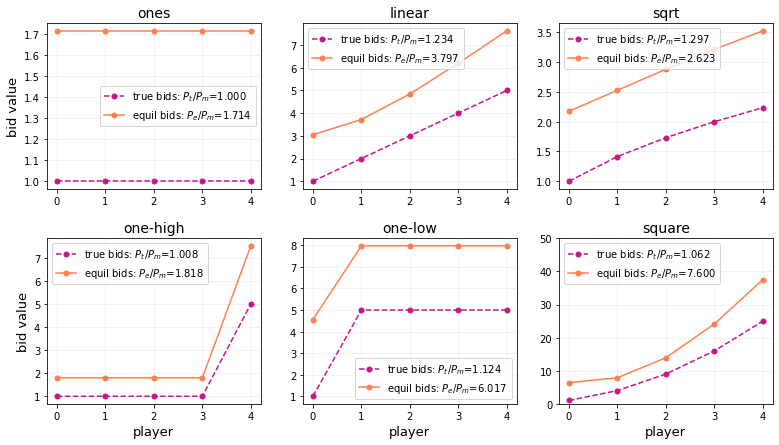

In [632]:
f, axarr = plt.subplots(nrows=2, ncols=3, figsize=(13,7))

candNames = ['ones', 'linear', 'sqrt', 'one-high', 'one-low', 'square']
for i, c in enumerate(cands):
    row, col = i // 3, i % 3
    
    truthCost = calcTruthfulPayment(c, a=3)
    if i == 5: # requires hand crafted init guess
        bids = calcEquilBids(c, n=5, a=3, guess=[6., 7., 13., 24., 27.])
    else:
        bids = calcEquilBids(c, n=5, a=3)
    for j in range(len(bids)):
        if np.abs(bids[j]) > float(1e5):
            bids[j] = 0
    equilCost = calcEquilPayment(c, bids, a=3)
    
    axarr[row,col].plot(np.arange(n), c, color='mediumvioletred', alpha=1, 
                        label=r'true bids: $P_t/P_m$={:0.3f}'.format(truthCost), marker='o', fillstyle='full', 
                        linestyle='--', markersize=5)
    axarr[row,col].plot(np.arange(n), bids, color='coral', alpha=1, 
                        label='equil bids: $P_e/P_m$={:0.3f}'.format(equilCost), marker='o', fillstyle='full', 
                        linestyle='-', markersize=5)

    axarr[row,col].set_title(candNames[i], size=14)
    axarr[row,col].legend()
    axarr[row,col].grid(alpha=0.2)


    
axarr[0,0].set_ylabel('bid value', size=13)
axarr[1,0].set_ylabel('bid value', size=13)
axarr[1,0].set_xlabel('player', size=13)
axarr[1,1].set_xlabel('player', size=13)
axarr[1,2].set_xlabel('player', size=13)

axarr[1,2].set_ylim(0, 50)


plt.subplots_adjust(hspace=0.3)
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# SYBIL proofness

In [635]:
def getAllocs(bids, alpha=3):
    denom = sum([1/(b**a) for b in bids])
    return np.array(1/(bids**a)) / denom

In [634]:
bids = calcEquilBids([4, 2], n=2, a=3, guess=[4,2])
bids

array([9.66287915, 8.8109329 ])

In [636]:
getAllocs(bids)

array([0.43121518, 0.56878482])

In [638]:
(bids-np.array([4,2]))*getAllocs(bids)

array([2.44191943, 3.87395527])

In [659]:
bids = calcEquilBids([10, 10, 2], n=3, a=3, guess=[4,4,2])
bids

array([17.14797398, 17.14797398, 11.90077619])

In [660]:
getAllocs(bids)

array([0.20033406, 0.20033406, 0.59933188])

In [663]:
out = (bids-np.array([10,10,2]))*getAllocs(bids)
out

array([1.43198265, 1.43198265, 5.93385079])

In [664]:
out[0]*2

2.8639653066137463